In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from learn_d_z import learn_d_z
from tqdm import tqdm
from update_z import update_z

# Executer le fichier build_dictionnary avant celui ci pour construire les dictionnaires si les fichiers data_atoms et data_spikes sont vide !

In [2]:
def MSE(s0,s1):
    return np.mean((s0-s1)**2)

index_1821 = 1.0*np.array([(i>=18*2)*(i<=21*2) for i in range(48)])
def MSE_1821(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_1821
    s1_reindex = s1.reshape(-1,48)*index_1821
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_1821)

index_813 = 1.0*np.array([(i>=8*2)*(i<=13*2) for i in range(48)])
def MSE_813(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_813
    s1_reindex = s1.reshape(-1,48)*index_813
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_813)

In [3]:
calendrier_challenge = pd.read_parquet("challenge_data/calendrier_challenge.parquet")
questionnaire = pd.read_parquet("challenge_data/questionnaire.parquet")
consos_challenge = pd.read_parquet("challenge_data/consos_challenge.parquet")
temperatures = pd.read_parquet("challenge_data/temperatures.parquet")



min_date = datetime.datetime(2009,7,15,12)
max_date=datetime.datetime(2011,1,1)
all_clients = list(set(consos_challenge["id_client"]))
day = datetime.datetime(2011,1,2)-datetime.datetime(2011,1,1)
clients_challenge = np.array(questionnaire[questionnaire["participe_challenge"]==True].id_client)
clients_nochallenge = np.array(questionnaire[questionnaire["participe_challenge"]==False].id_client)
all_clients = list(set(consos_challenge["id_client"]))
hour = datetime.datetime(2011,1,2,12)-datetime.datetime(2011,1,2,11)



def load_signal(id_client,min_time,max_time):
    """
    Load the signal of client_id between min_time and max_time
    """
    consos = consos_challenge[consos_challenge["id_client"]==id_client]
    consos = consos[consos["horodate"]>=min_time]
    return consos[consos["horodate"]<max_time]["puissance_W"]

def reconstruction(atom,spike):
    """
    Return the signal based on the atoms and the activation signal
    """
    return np.sum([np.convolve(atom[i],spike[i]) for i in range(len(atom))], axis=0)


In [69]:
n_days = (max_date-min_date).days-365+21
n_times = n_days*48
n_atoms = 15
length_atoms = 48
coef_reg = 0.5
reg = np.ones(n_times-length_atoms+1)
t_j = np.linspace(-12,12,48)
x_j = 1+t_j**2


for i in range(n_times//48-1):
    reg[48*i:48*(i+1)]=x_j
reg = reg*coef_reg

# Construct the activation signals for the test dataset
for client in tqdm(clients_challenge):
    atom = np.load('data_atoms/'+str(client)+'.npy')
    signaltest_client = np.array(load_signal(client,min_date+(365-21)*day,max_date-12*hour)).reshape(1,-1)

    for i in range(70):
        if i==0:
            spike_test = update_z(signaltest_client,atom,reg) 
        else:
            spike_test = update_z(signaltest_client,atom,reg,z0=spike_test)
    np.save('data_spike_test/'+str(client)+'.npy',spike_test)

    
for client in tqdm(clients_nochallenge):
    atom = np.load('data_atoms/'+str(client)+'.npy')
    signaltest_client = np.array(load_signal(client,min_date+(365-21)*day,max_date-12*hour)).reshape(1,-1)

    for i in range(70):
        if i==0:
            spike_test = update_z(signaltest_client,atom,reg) 
        else:
            spike_test = update_z(signaltest_client,atom,reg,z0=spike_test)
    np.save('data_spike_test/'+str(client)+'.npy',spike_test)



In [70]:
# Load the datasets
atoms_X = []
spikes_X_train = []
spikes_X_test = []
atoms_y = []
spikes_y_train = []
spikes_y_test = []
n_clients=len(all_clients)
for client in clients_nochallenge:
    atoms_X.append(np.load('data_atoms/'+str(client)+'.npy'))
    spikes_X_train.append(np.load('data_spike/'+str(client)+'.npy'))
    spikes_X_test.append(np.load('data_spike_test/'+str(client)+'.npy'))
for client in clients_challenge:
    atoms_y.append(np.load('data_atoms/'+str(client)+'.npy'))
    spikes_y_test.append(np.load('data_spike_test/'+str(client)+'.npy'))
    spikes_y_train.append(np.load('data_spike/'+str(client)+'.npy'))

times = np.concatenate((np.linspace(12,23.5,24),np.linspace(0,11.5,24)))


In [71]:
X_train = np.array(spikes_X_train)
X_train=X_train.reshape(-1,X_train.shape[-1])
y_train = np.array(spikes_y_train)
y_train=y_train.reshape(-1,y_train.shape[-1])



X_test = np.array(spikes_X_test)
X_test=X_test.reshape(-1,X_test.shape[-1])[:,21*48:]
y_test = np.array(spikes_y_test)
y_test=y_test.reshape(-1,y_test.shape[-1])[:,21*48:]

print(X_train.shape,y_train.shape)

(4620, 17473) (4605, 17473)


In [72]:
from sklearn.linear_model import Lasso, Ridge

model=Ridge(1000)
model.fit(X_train.T,y_train.T)
print(np.sum(model.coef_>0))

8943713


In [73]:
y_predict = model.predict(X_test.T).T

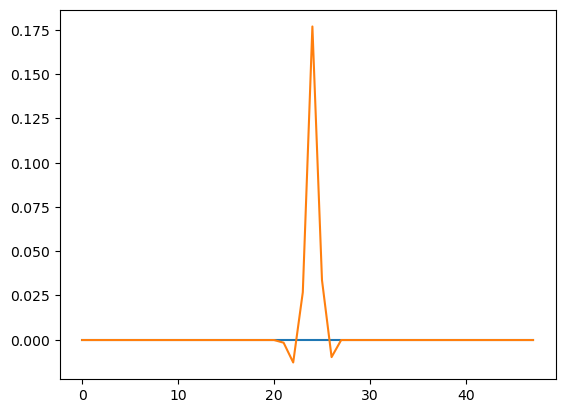

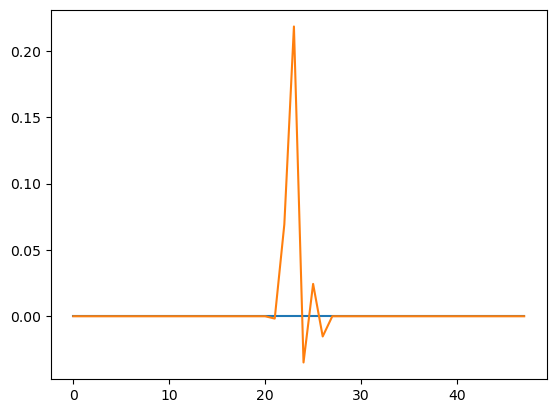

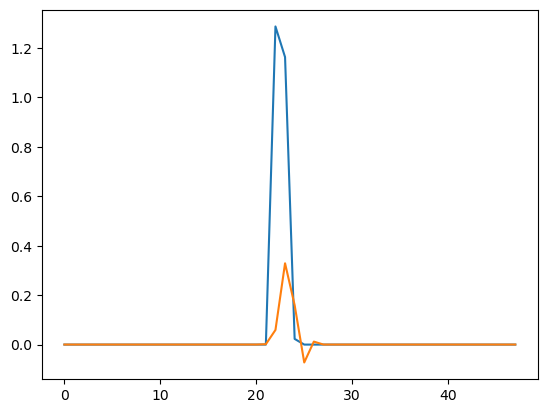

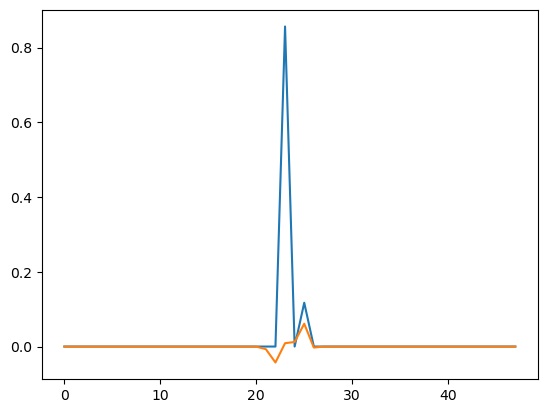

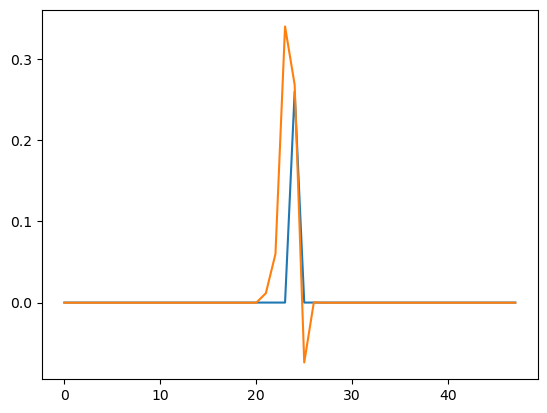

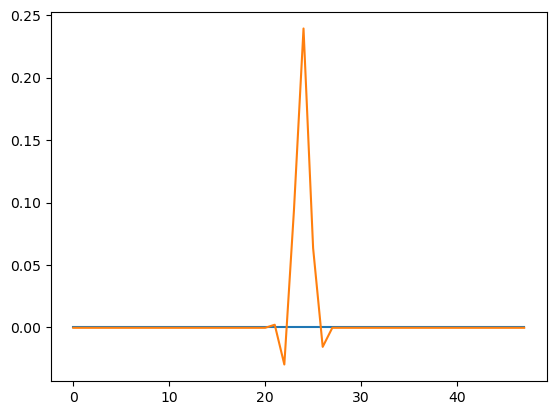

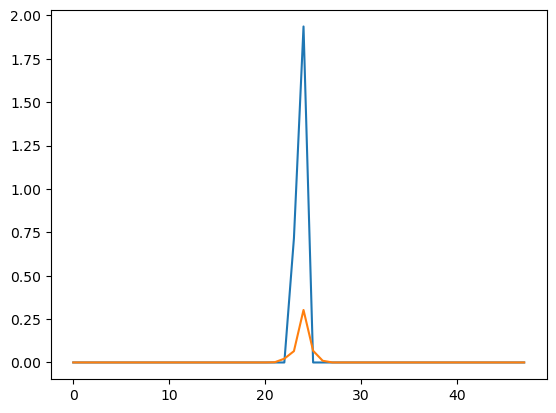

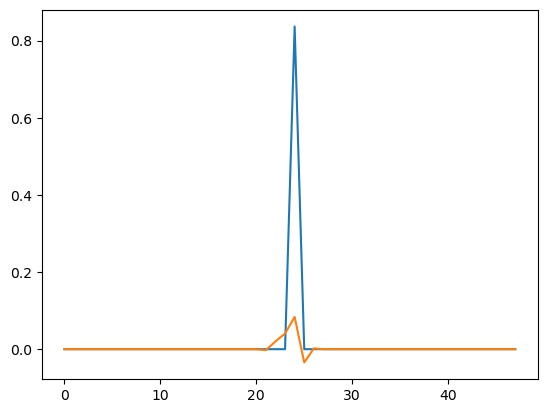

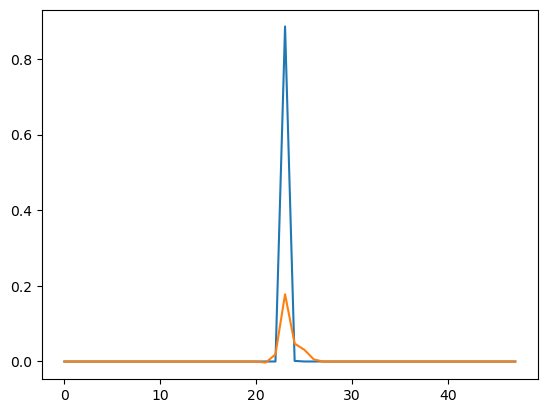

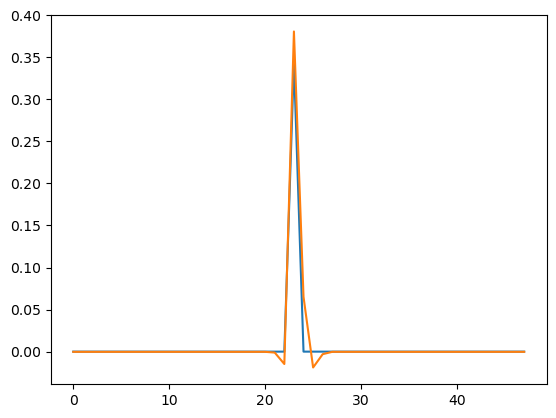

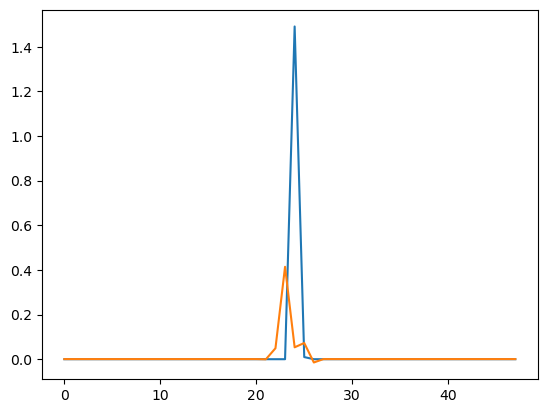

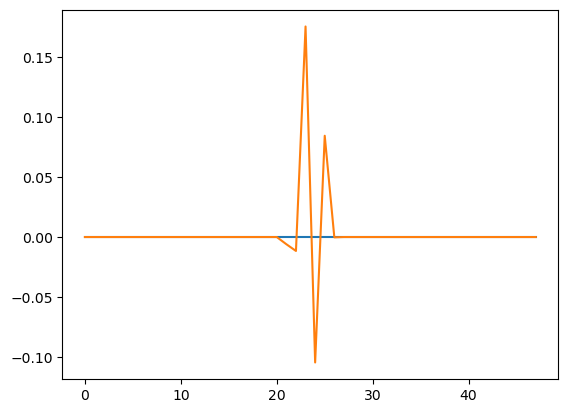

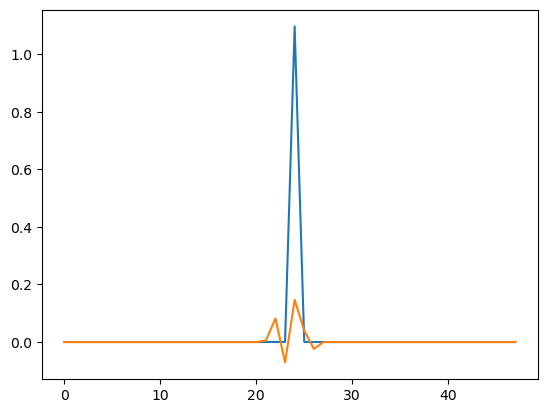

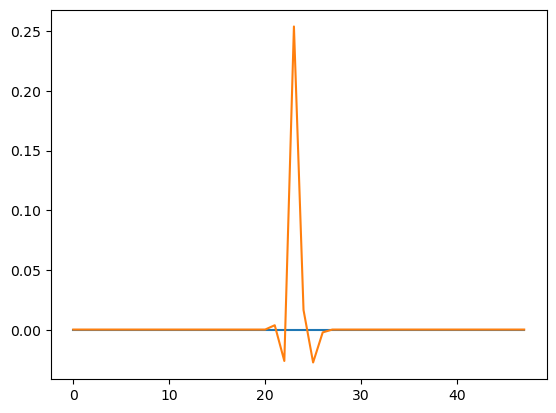

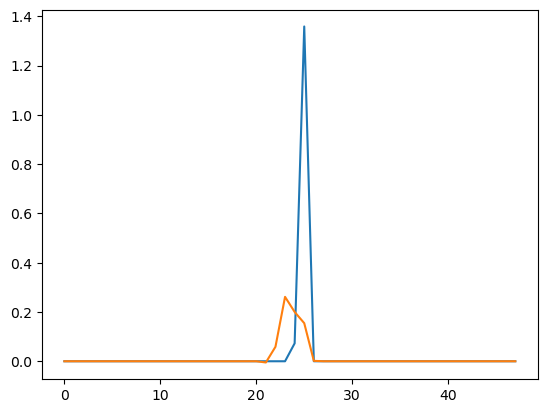

In [74]:
# Plot shape of activation signals

for i in range(15):
    plt.plot(y_test[i,48:48*2])
    plt.plot(y_predict[i,48:48*2])
    plt.show()

# Reconstruction

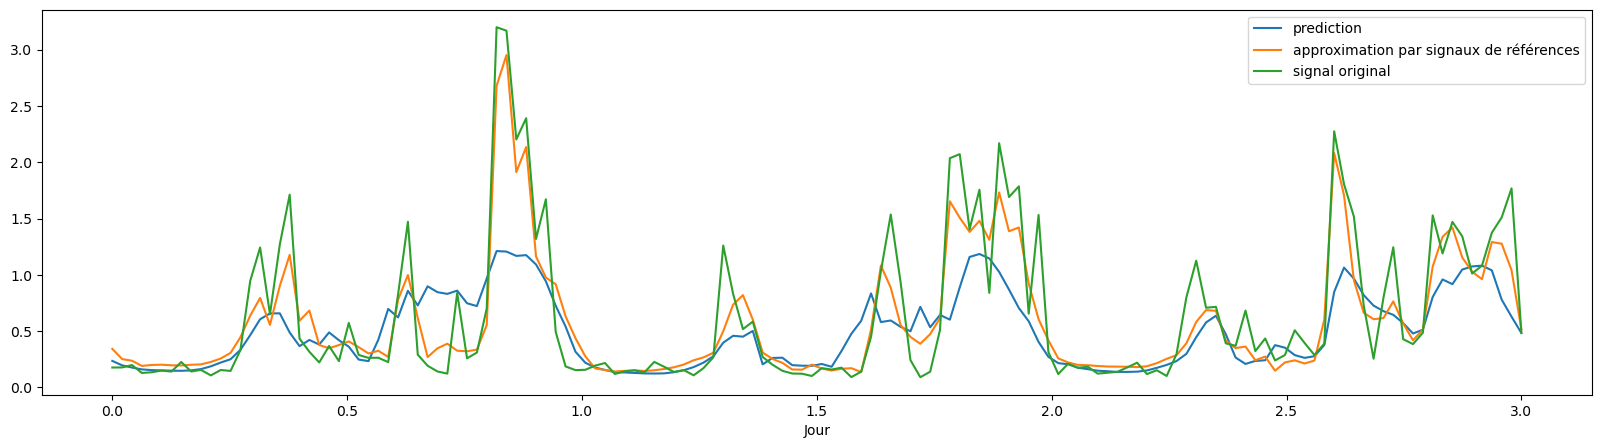

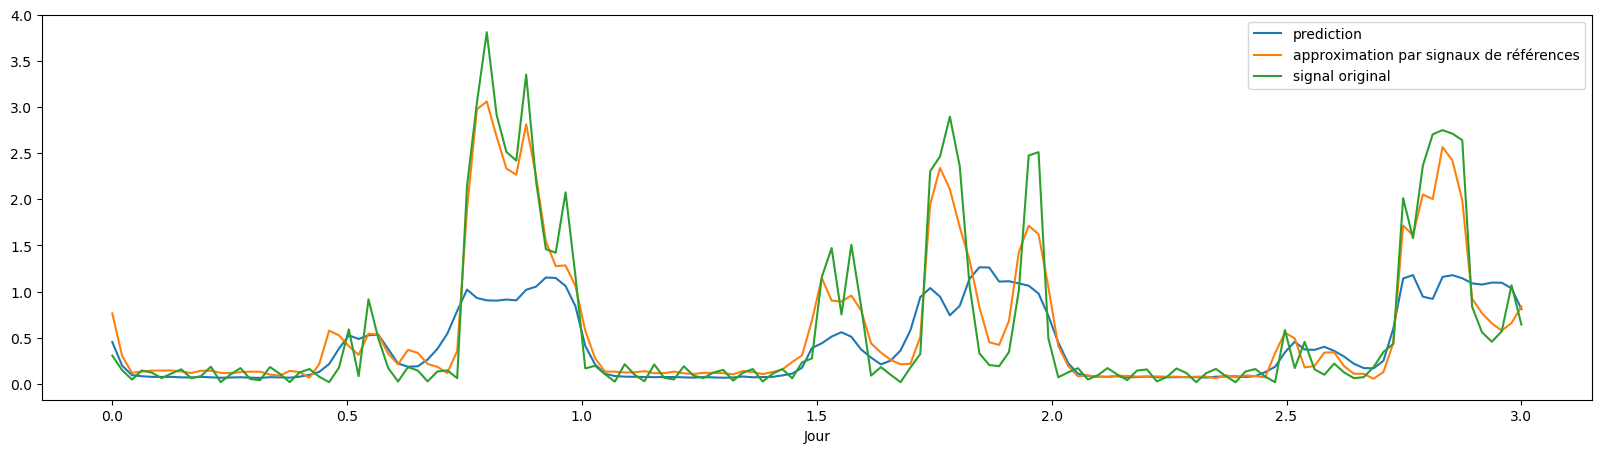

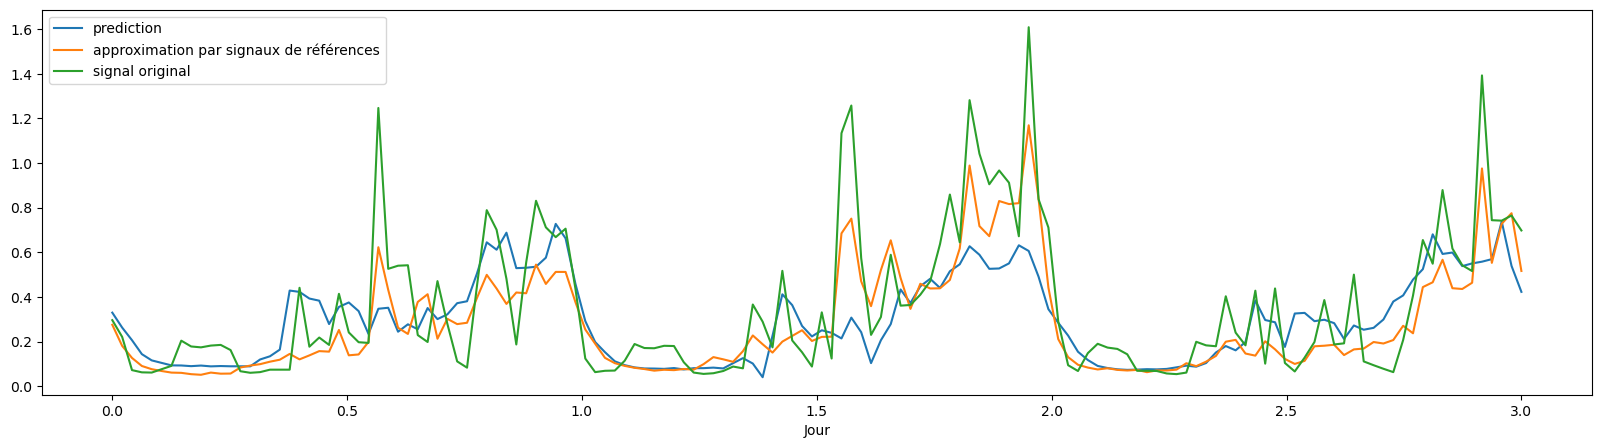

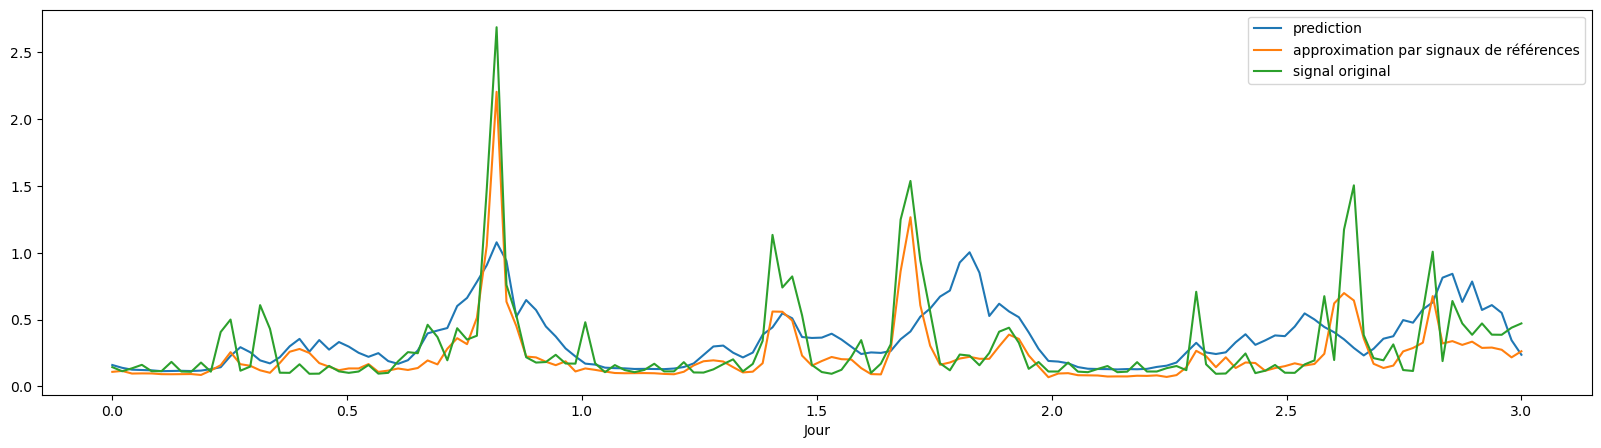

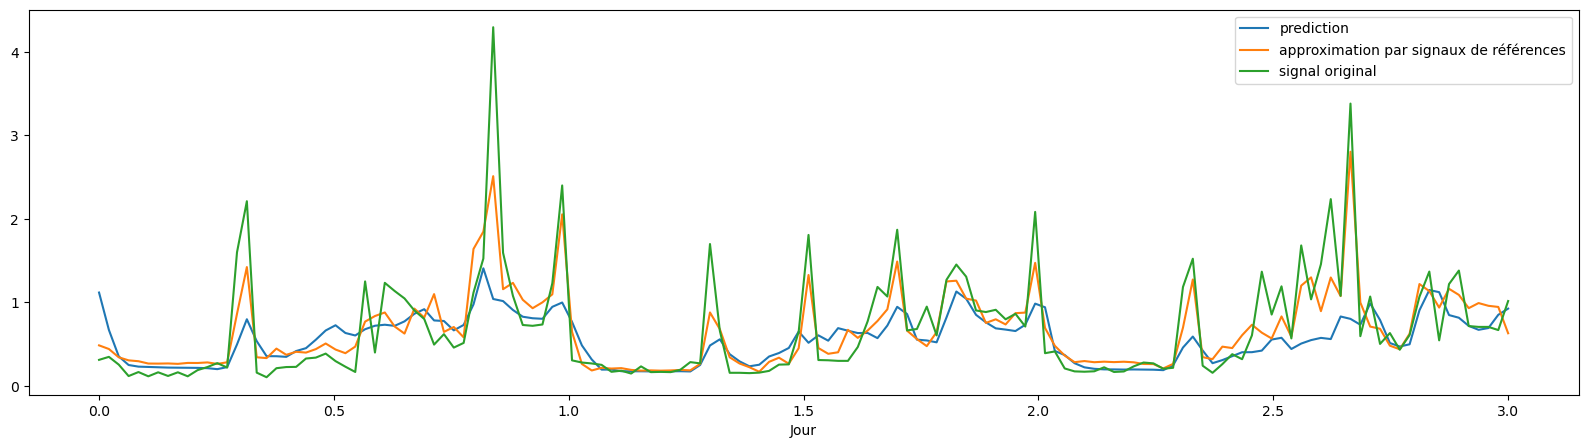

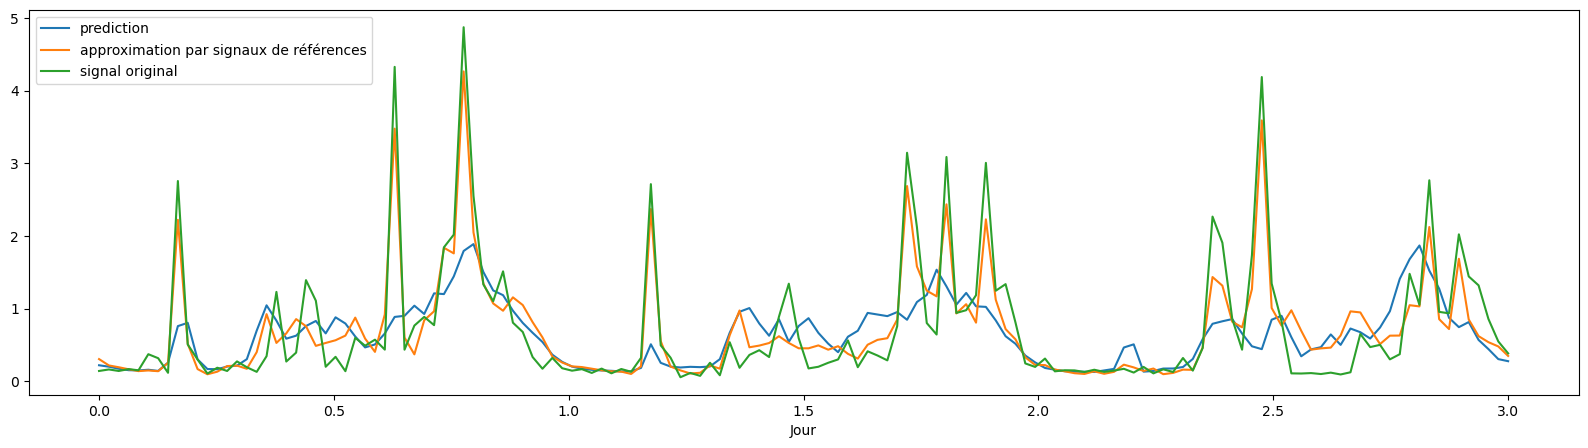

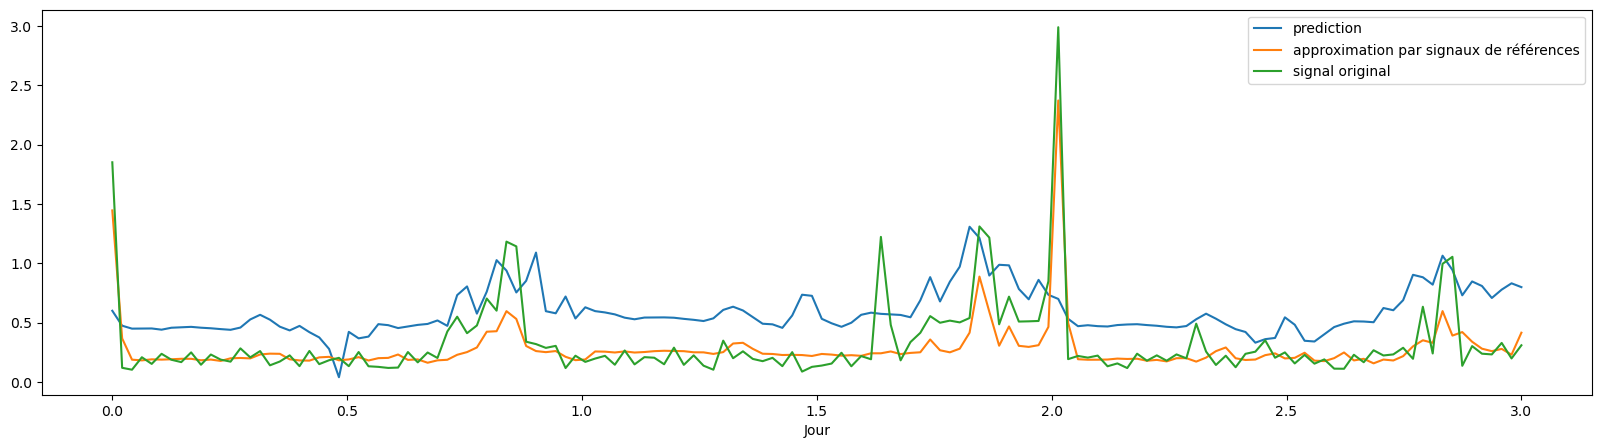

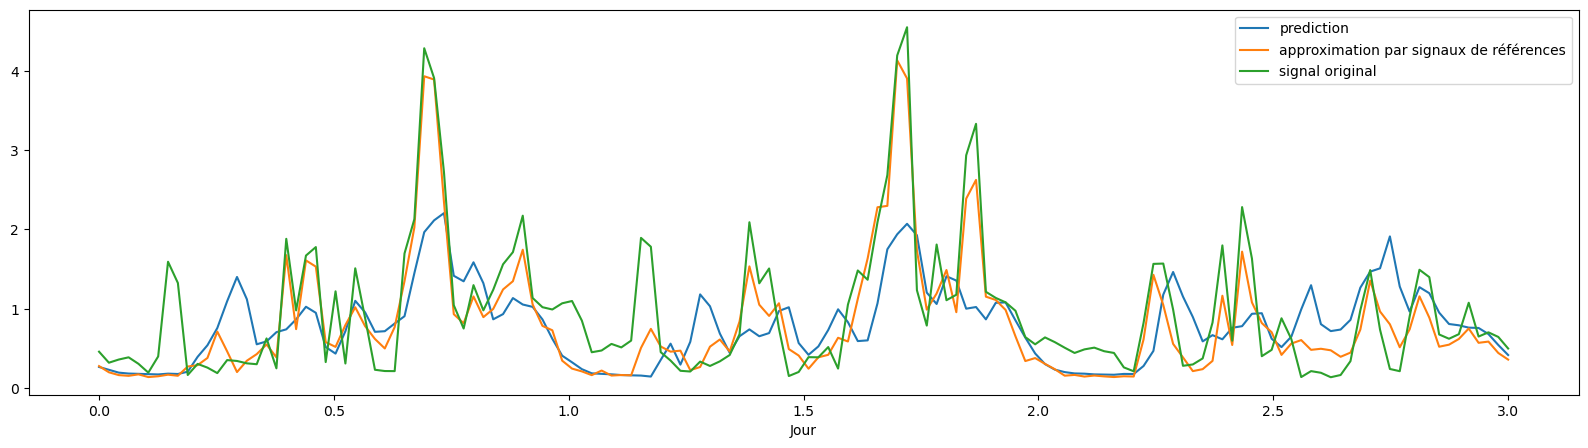

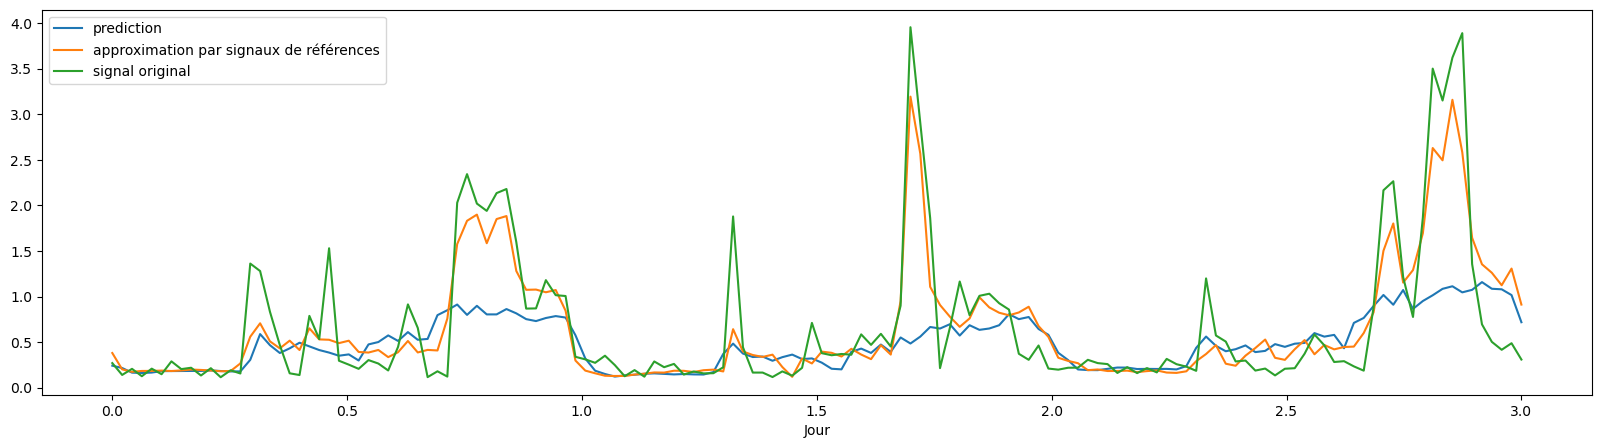

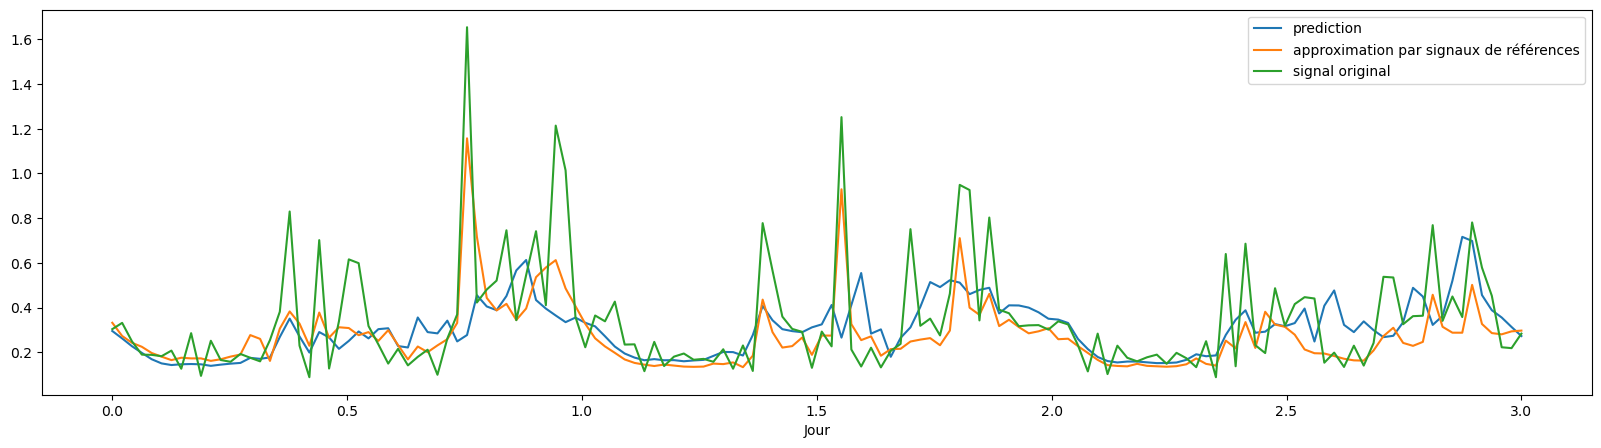

0.33954308925184334
0.321149313432259
0.5235989817190752
0.4434263165735227


In [81]:
mean_MSE = []
mean_MSE1821 = []
mean_MSE813 = []
mean_MAE = []

for i in range(len(clients_challenge)):
    original_signal = load_signal(clients_challenge[i],min_date+365*day,max_date-12*hour)[24:-24]
    spikes_1 = y_predict[15*i:15*(i+1)]
    atoms_1 = np.array(atoms_y)[i]
    signal_1 = reconstruction(atoms_1,spikes_1)[24:-24]
    signal_approximation = reconstruction(atoms_1,y_test[15*i:15*(i+1)])[24:-24]

    mean_MSE.append(MSE(original_signal,signal_1))
    mean_MSE1821.append(MSE_1821(np.array(original_signal),signal_1))
    mean_MSE813.append(MSE_813(np.array(original_signal),signal_1))
    mean_MAE.append(np.mean(np.abs(np.array(original_signal)-signal_1)))

    if i<10:
        plt.figure(figsize=(20,5))
        plt.plot(np.linspace(0,3,48*3),signal_1[48*90:48*93],label='prediction')
        plt.plot(np.linspace(0,3,48*3),signal_approximation[48*90:48*93],label='approximation par signaux de références')
        plt.plot(np.linspace(0,3,48*3),original_signal[48*90:48*93],label='signal original')
        plt.xlabel('Jour')
        plt.legend()
        plt.show()
print(np.mean(mean_MSE))
print(np.mean(mean_MAE))
print(np.mean(mean_MSE1821))
print(np.mean(mean_MSE813))